In [ ]:
import sys
import os
project_root = os.path.abspath('..')
print(f"root:{project_root}")
if project_root not in sys.path:
    sys.path.append(project_root)

from src.utils.data_importer import data_loader


Project root directory: c:\Users\romul\Repositories\pBGSK


In [ ]:
import pandas as pd
import random
import numpy as np
import sys
import sklearn as sk
import matplotlib.pyplot as plt


In [ ]:
df = data_loader('tic_tac_toe_endgame')


In [ ]:
mapping = { 'x': 1, 'o': -1, 'b': 0 }
df.data.features = df.data.features.replace(mapping)

C:\Users\romul\AppData\Local\Temp\ipykernel_15644\1260285718.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.data.features = df.data.features.replace(mapping)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

#from ucimlrepo import fetch_dataset

In [ ]:

class Individual:
    def __init__(self,data_set_name: str,individual_id :int, features: list,X_train,X_test,y_train, y_test,columns_names):
        """Cada individuo possui um vetor binário representando a seleção de features."""
        self.data_set_name = data_set_name
        self.number_of_features = int(np.sum(features))
        self.individual_id = individual_id
        self.features = features # vetor [True,False,True]
        self.numeric_features = features +0# vetor [1,0,1]
        
        self.column_names = columns_names
        self.X_train = X_train
        self.X_test= X_test
        self.y_train = y_train
        self.y_test = y_test
        #sk.model_selection.train_test_split(self.features, self.targets, test_size=0.33, random_state=42)
        self.score = 2
        self.classifier = KNeighborsClassifier(n_neighbors=5)
        self.df = None

    def calculate_fitness(self):
        """ 1 - acuracia  + 1 - features utilizadas /total de features  """
    # Get the indices of the selected features (where feature == 1)
        #selected_indices = np.where(self.features == 1)[0]
        
        if sum(self.features) == 0:
            self.score = 0.0
            return

        # Select the features from the data
        X_train_selected = self.X_train.loc[:, self.features]
        X_test_selected = self.X_test.loc[:, self.features]

        # Train and score the model
        self.classifier.fit(X_train_selected, self.y_train)
        y_pred = self.classifier.predict(X_test_selected)
        self.score = 1-accuracy_score(self.y_test, y_pred) + 1-(sum(self.numeric_features))/len(self.features)

class Population:

    def __init__(self, individuals: list):
        self.individuals = individuals
        self.len = len(individuals)
        self.df =None
        self.geng_df =pd.DataFrame()


    def sort_by_fitness(self):
        for indiv in self.individuals:
            indiv.calculate_fitness()
        self.individuals.sort(key=lambda ind: ind.score)
        self.df.sort_values('score',ascending=False)
    

    def beginner_gsk(self,knowledge_ratio=0.5):    
        for t_idx in range(1,self.len-1):
            for d in range(len(self.individuals[0].features)):
                if random.random() <knowledge_ratio:
                    rand_idx = int(random.random()*self.len)
                    rand_indiv = self.individuals[rand_idx]
                    xt =self.individuals[t_idx]
                    
                    prev_idx = t_idx-1
                    next_idx = t_idx+1
                    t_prev =self.individuals[prev_idx] if (prev_idx <0) else self.individuals[prev_idx+1]
                    t_next =self.individuals[next_idx+1] if (next_idx +1<len(self.individuals)) else self.individuals[next_idx]

                    if xt.score>rand_indiv.score:
                        xtk =xt.numeric_features[d] + (t_prev.numeric_features[d] -t_next.numeric_features[d] )+(xt.numeric_features[d]- rand_indiv.numeric_features[d] )
                    else:
                        xtk =xt.numeric_features[d] + (t_prev.numeric_features[d] -t_next.numeric_features[d] )+(xt.numeric_features[d]- rand_indiv.numeric_features[d] )
                    self.individuals[t_idx].features[d] =(xtk >0)
                    
                    self.individuals[t_idx].numeric_features[d] = (xtk >0) +0


    def intermediate_gsk(self,knowledge_ratio=0.5):
        l = int(self.len/3)
        for t_idx in range(1,self.len-1):
                    for dimension in range(len(self.individuals[0].features)):
                        if random.random() <knowledge_ratio:
                            rand_idx = int(random.random()*len(self.individuals))
                            rand_indiv = self.individuals[rand_idx]
                            xt =self.individuals[t_idx]

                            best_idx = np.random.randint(0,l)
                            middle_idx = np.random.randint(l,self.len-l)
                            worst_idx= np.random.randint(self.len-l,self.len)

                            best_x = self.individuals[best_idx]
                            middle_x = self.individuals[middle_idx]
                            worst_x = self.individuals[worst_idx]

                            if xt.score>rand_indiv.score:
                                xtk =xt.numeric_features[dimension] + (best_x.numeric_features[dimension] -worst_x.numeric_features[dimension] )+(middle_x.numeric_features[dimension]- xt.numeric_features[dimension] )#ainda falta o kf
                            else:
                                xtk =xt.numeric_features[dimension] + (best_x.numeric_features[dimension] -worst_x.numeric_features[dimension] )+(xt.numeric_features[dimension]- middle_x.numeric_features[dimension] )# ainda falta o kf
                            self.individuals[t_idx].features[dimension] =(xtk >0)

                            self.individuals[t_idx].numeric_features[dimension] = (xtk >0) +0

    def population_reduction(self, generation_atual, generation_max,low_b=0.12,high_b=0.6):
        #if int(self.len*low_b) < len(population):
        np_min =self.len*low_b
        np_max =self.len*high_b
        old_len = self.len
        np_new = int((np_min - np_max) * (generation_atual / generation_max) + np_max -1)
        self.df.columns[:-2]
        k =self.df.loc[:,self.df.columns[:-2]].sum(axis=0)
        kf = pd.DataFrame([k] )
        self.geng_df = pd.concat([kf,self.geng_df])
        if np_new >12:#minimo viavel
            for i in range(old_len - np_new):
                self.individuals.pop()
                self.len -=1
            print(np_new)
            return False
        else:
            return True

    def ploting_score(self):
        import seaborn as sns

        df_p = pd.DataFrame()
        for column in self.df.columns[:-2]:
            row ={ 'feature':f'{column}','score':self.df[self.df.loc[:,column]]['score'],'n_features':self.df[self.df.loc[:,column]]['n_features']}
            row =pd.DataFrame(row)
            df_p=pd.concat([row,df_p],ignore_index=True)
        f, ax = plt.subplots(figsize=(7, 6))
        # Plot the orbital period with horizontal boxes
        sns.boxplot(
            df_p, x="score", y="feature", hue="feature",
            whis=[0, 100], width=.6, palette="vlag"
        )
        sns.stripplot(df_p, x="score", y="feature", size=4, color=".3")

        ax.xaxis.grid(True)
        ax.set(ylabel="")
        sns.despine(trim=True, left=True)

    def dataframe(self):
        
        lista_features = [indiv.features for indiv in self.individuals]
        pop_df = pd.DataFrame(np.array(lista_features),columns=self.individuals[0].column_names)
        pop_df['score']= [indiv.score for indiv in self.individuals]
        pop_df['n_features'] = pop_df.loc[:,pop_df.columns!='score'].sum(axis=1)
        self.df =pop_df
        return pop_df


In [ ]:
def population_creation(num_population:int, lower_k :int, upper_k:int,data_tuple,data_set_name,columns_names) -> Population:
    """Criando uma população inicial de indivíduos. com features variando entre lower_k e upper_k.
    num_population: número de indivíduos na população"""
    X_train, X_test, y_train, y_test = data_tuple
    population = []
    total_features = X_train.shape[1]
    for i in range(num_population):
        k = lower_k + random.random()*(upper_k-lower_k)
        k = int(k)
        features = random.sample(range(0, total_features), k)
        bin_feature = np.array([False]*total_features)

        for feature in features:
            bin_feature[feature] = True  # Mark selected

        indiv = Individual(data_set_name=data_set_name,
                individual_id=i,
                features=bin_feature,
                X_train=X_train,  # Pass the reference
                y_train=y_train,  # Pass the reference
                X_test=X_test,    # Pass the reference
                y_test=y_test,     # Pass the reference
                columns_names=columns_names
            )
        population.append(indiv)
    pop =Population(population)
    return pop

In [ ]:
def stage_dimension(gem_max:int, gem_atual:int,k_rate:float, num_individuos:int):
    """gem_max é numero máximo de gerações
        gem_atual é a geração atual
        d_junior é o número de indivíduos juniores
        d_senior é o número de indivíduos seniores
        k_rate é o knowledge rate"""
        
    d_junior = int(num_individuos*((gem_max - gem_atual)/gem_max)**k_rate)
    d_senior = num_individuos - d_junior
    return d_junior, d_senior


C:\Users\romul\AppData\Local\Temp\ipykernel_15644\528165691.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.data.features = df.data.features.replace(mapping)


Individual 0 Features: 3 Score: 1.0673
Individual 1 Features: 1 Score: 1.2107
Individual 2 Features: 1 Score: 1.2107
Individual 3 Features: 2 Score: 1.1816
Individual 4 Features: 3 Score: 0.9380
Individual 5 Features: 2 Score: 1.1469
Individual 6 Features: 3 Score: 1.0042
Individual 7 Features: 1 Score: 1.2107
Individual 8 Features: 3 Score: 0.9600
Individual 9 Features: 1 Score: 1.2107
Individual 10 Features: 2 Score: 1.1059
Individual 11 Features: 2 Score: 1.0680
Individual 12 Features: 1 Score: 1.2107
Individual 13 Features: 3 Score: 0.9947
Individual 14 Features: 1 Score: 1.2107
Individual 15 Features: 3 Score: 1.0421
Individual 16 Features: 3 Score: 0.9537
Individual 17 Features: 2 Score: 1.0964
Individual 18 Features: 3 Score: 1.0673
Individual 19 Features: 3 Score: 1.0421
Individual 20 Features: 3 Score: 1.0641
Individual 21 Features: 2 Score: 1.1532
Individual 22 Features: 1 Score: 1.2107
Individual 23 Features: 2 Score: 1.0775
Individual 24 Features: 3 Score: 0.9916
Individual

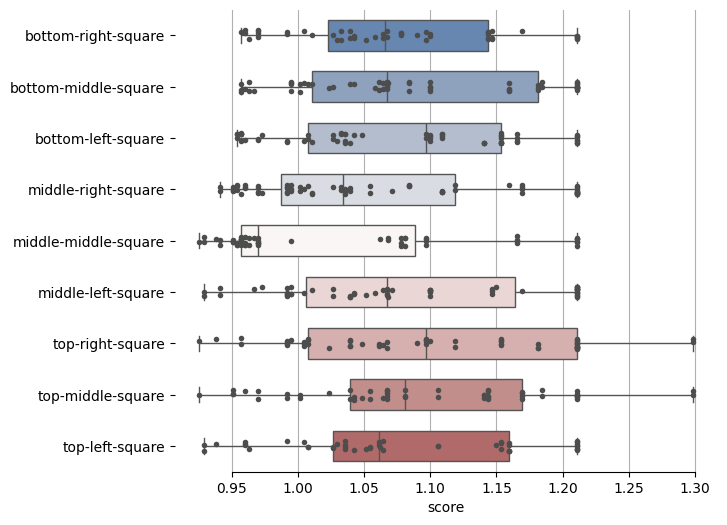

In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np
mapping = { 'x': 1, 'o': -1, 'b': 0 }
data_set_name = 'tic_tac_toe_endgame'
df = data_loader(data_set_name)
columns_names = df.data.features.columns
df.data.features = df.data.features.replace(mapping)
X =df.data.features
y = np.ravel(df.data.targets)
data_tuple = sk.model_selection.train_test_split(X, y, test_size=0.33, random_state=42)
# 2. Create the population
# This passes the data references to all individuals
num_population = 250
lower_k=1
upper_k=4
pop = population_creation(
    num_population=num_population,
    lower_k=lower_k,
    upper_k=upper_k,
    data_tuple=data_tuple,
    data_set_name=data_set_name,
    columns_names=columns_names
)

# 3. Calculate fitness for each individual
for indiv in pop.individuals:
    indiv.calculate_fitness()
    print(f"Individual {indiv.individual_id} Features: {indiv.number_of_features} Score: {indiv.score:.4f}")
#beginners_sharing_phase()
pop.dataframe()
pop.sort_by_fitness()
i=0
pop.ploting_score()
while i<50 and pop.len>12:
    i+=1
    pop.beginner_gsk()
    pop.intermediate_gsk()
    if pop.population_reduction(i,50):
        break


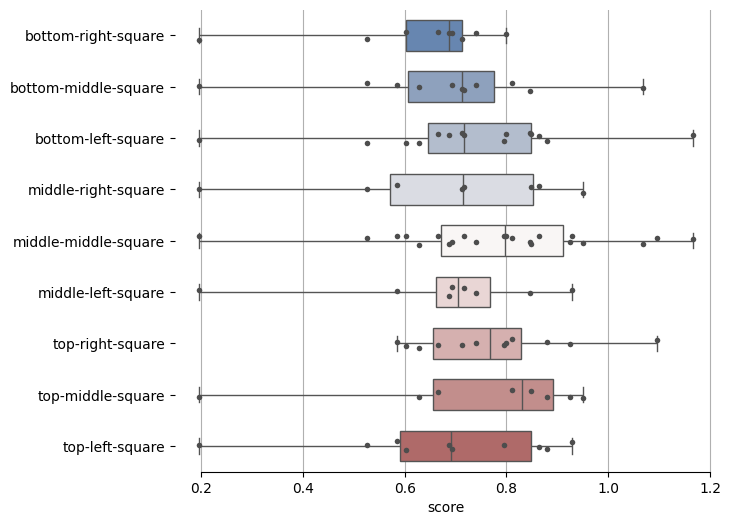

In [ ]:
pop.sort_by_fitness()
pop.dataframe()
pop.ploting_score()

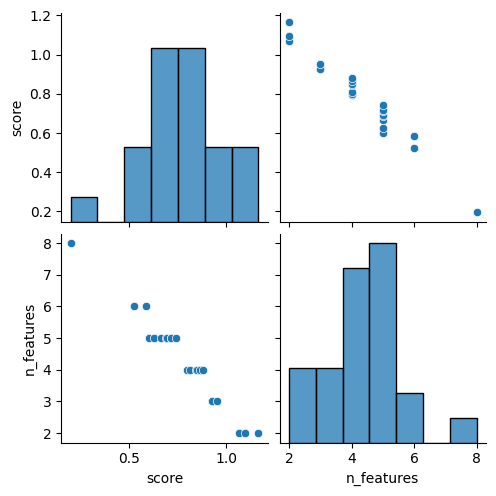

In [ ]:
import seaborn as sns
sns.pairplot(pop.df[['score','n_features']])

In [ ]:
print(pop.individuals[-1].score,pop.individuals[-1].numeric_features)
print(pop.individuals[0].score,pop.individuals[0].numeric_features)

1.165790396074308 [0 0 0 0 1 0 1 0 0]
0.19628461268839814 [1 1 0 1 1 1 1 1 1]


In [ ]:
#Rascunho da feature popularity per 
pop.df.columns[:-2]
k =pop.df.loc[:,pop.df.columns[:-2]].sum(axis=0)
kf = pd.DataFrame([k] )
kf

,top-left-square,top-middle-square,top-right-square,middle-left-square,middle-middle-square,middle-right-square,bottom-left-square,bottom-middle-square,bottom-right-square
0,10,8,12,8,22,8,15,11,9


In [14]:
import random
import numpy as np
total_features = 10
nfe = 350
t_nfe = 1000
k = int(total_features*(1-nfe/t_nfe))
features = random.sample(range(0, total_features), k)
jun_bin_feature = np.array([False]*total_features)
for feature in features:
    jun_bin_feature[feature] = True  # Mark selected

In [15]:
jun_bin_feature
senior_bin_feature = np.array([1]*total_features) - jun_bin_feature
senior_bin_feature

array([0, 0, 0, 0, 1, 1, 1, 1, 0, 0])

In [29]:
np.where(senior_bin_feature>0)

(array([4, 5, 6, 7], dtype=int64),)